In [ ]:
%%capture
!pip install swig
!pip install gymnasium
!pip install gym[box2d]

In [ ]:
# Define environment for RL agent and for evaluation episodes
import gymnasium as gym

env = gym.make('CarRacing-v2', continuous = False, render_mode = "rgb_array")
eval_env = gym.make('CarRacing-v2', continuous = False, render_mode = "rgb_array")

In [ ]:
import torch
import torch.nn as nn
import collections
import copy
import tqdm
import random
import math
import numpy as np
from PIL import Image

# Environment constants
INPUT_DIM = 96
ACTIONS = 5
EXPERIENCE_MEM = int(5e4)

# Model architecture
policy_conv_sz = [(1, 8, 8, 4), (8, 32, 4, 2)]
policy_linear_sz = [(10 * 10 * 32, 128), (128, ACTIONS)]
Q_conv_sz = [(1, 8, 8, 4), (8, 32, 4, 2)]
Q_linear_sz = [(10 * 10 * 32, 128), (128, ACTIONS)]

# RL hyper-parameters
CYCLES = 35000
EXPLORE_CYCLES = 10
RANDOM_EXPLORE_CYCLES = 5000
UPDATE_CYCLES = 1
EVAL_FREQ = 500
BATCH_SZ = 128
GAMMA = 0.99
TAU = 0.02
GOAL_ENTROPY = -ACTIONS

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def gs(o):
    if o is None:
        return None
    return (o[:, :, 0] * 0.299 + o[:, :, 1] * 0.587 + o[:, :, 2] * 0.114 - 127.5) / 255 # Grayscale and normalize RGB image inputs

In [ ]:
def layer_init(m):
    if type(m) is nn.Linear or type(m) is nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [ ]:
# ConvNet used for policy and Q-value functions
class ConvNet(nn.Module):
    def __init__(self, conv_sz, model_sz, act_fn):
        super().__init__()
        self.conv = nn.Sequential(
            *[nn.Conv2d(w, x, y, z) if i % 2 == 0 else nn.ReLU() for w, x, y, z in conv_sz for i in range(2)]
        ).apply(layer_init)
        self.flatten = nn.Flatten()
        self.lin = nn.Sequential(
            *[nn.Linear(x, y) if i % 2 == 0 else nn.ReLU() for x, y in model_sz for i in range(2)]
        ).apply(layer_init)
        if act_fn is None:
            self.lin = self.lin[:-1]
        else:
            self.lin[-1] = act_fn

    def forward(self, inp):
        batch_sz = inp.shape[0]
        res = self.conv(inp)
        res = self.flatten(res)
        return self.lin(res)

In [ ]:
# Define memory for experience learning
Experience = collections.namedtuple('Experience', ('cur_state', 'action', 'reward', 'future_state'))
memory = collections.deque(maxlen = EXPERIENCE_MEM)

In [ ]:
policy = ConvNet(policy_conv_sz, policy_linear_sz, nn.Softmax(dim = -1)).to(device)
Q1 = ConvNet(Q_conv_sz, Q_linear_sz, None).to(device)
Q2 = ConvNet(Q_conv_sz, Q_linear_sz, None).to(device)
Q1targ = copy.deepcopy(Q1)
Q2targ = copy.deepcopy(Q2)
policy_opt = torch.optim.AdamW(policy.parameters(), lr = 3e-4, eps = 1e-4)
Q_opt = torch.optim.AdamW(list(Q1.parameters()) + list(Q2.parameters()), lr = 3e-4, eps = 1e-4)
log_alpha = torch.tensor(0.0, requires_grad = True)
log_alpha_opt = torch.optim.AdamW([log_alpha], lr = 1e-2, eps = 1e-4)

In [ ]:
# Load pretrained policyu
load_policy = True

if load_policy:
    from google.colab import drive
    drive.mount('/content/gdrive')
    policy.load_state_dict(torch.load("/content/gdrive/My Drive/RL_SACVision/policy.pth"))


Mounted at /content/gdrive


In [ ]:
# Safe logarithm avoiding log(0) problems
def log(inp):
    return torch.log(inp + (inp == 0.0) * 1e-8)

In [ ]:
total_explores = 0
cur_epoch_steps = 0
epoch_steps_graph = []
Q1_loss_graph = []
Q2_loss_graph = []
policy_loss_graph = []
alpha_loss_graph = []
log_alpha_graph = []
rewards_graph = []
Q_norms = []
state = None

with tqdm.tqdm(total = CYCLES) as t:
    for cyc_num in range(CYCLES):
        if cyc_num % EVAL_FREQ == 0:
            eval_state, _ = eval_env.reset()
            eval_state = gs(eval_state)
            eval_terminated = False
            eval_truncated = False
            total_reward = 0
            while not (eval_terminated or eval_truncated):
                eval_state, eval_reward, eval_terminated, eval_truncated, _ = eval_env.step(int(torch.argmax(policy(torch.tensor(eval_state, device=device, dtype = torch.float32).unsqueeze(dim = 0).unsqueeze(dim = 0)))))
                eval_state = gs(eval_state)
                total_reward += eval_reward
            rewards_graph.append(total_reward)
            print(f"Current Evaluation Reward: {total_reward}")
        for j in range(EXPLORE_CYCLES):
            if state is None or cur_epoch_steps > 100 * math.pow(1.0002, cyc_num):
                epoch_steps_graph.append(cur_epoch_steps)
                cur_epoch_steps = 0
                state, _ = env.reset()

            if total_explores < RANDOM_EXPLORE_CYCLES:
                action = random.randint(0, ACTIONS - 1)
            else:
                probs = torch.distributions.Categorical(policy(torch.tensor(gs(state), device=device, dtype = torch.float32).unsqueeze(dim = 0).unsqueeze(dim = 0)))
                action = int(probs.sample())
            new_state, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                new_state = None

            if cur_epoch_steps != 0:
              memory.append(Experience(gs(state), action, reward, gs(new_state)))
            state = new_state

            total_explores += 1
            cur_epoch_steps += 1

        if len(memory) > BATCH_SZ:
            for j in range(UPDATE_CYCLES):
                experiences = random.sample(memory, BATCH_SZ)
                states = []
                rewards = []
                actions = []
                future_states = []
                future_states_not_none = []

                for idx, i in enumerate(experiences):
                    states.append(i.cur_state)
                    rewards.append(i.reward)
                    actions.append(i.action)
                    if i.future_state is not None:
                        future_states_not_none.append(idx)
                        future_states.append(i.future_state)

                states = np.array(states)
                rewards = np.array(rewards)
                future_states = np.array(future_states)

                states = torch.tensor(states, device = device, dtype = torch.float32).unsqueeze(dim = 1)
                rewards = torch.tensor(rewards, device = device)
                future_states = torch.tensor(future_states, device = device, dtype = torch.float32).unsqueeze(dim = 1)

                # Update Q1 and Q2
                Q1.zero_grad(set_to_none = True)
                Q2.zero_grad(set_to_none = True)
                q1_pred = Q1(states)[torch.arange(len(actions)), actions]
                q2_pred = Q2(states)[torch.arange(len(actions)), actions]
                Q_norms.append(torch.norm(q1_pred).item())

                V = torch.zeros_like(rewards, device=device, dtype = torch.float32)
                V[future_states_not_none] = torch.sum(policy(future_states) * (torch.min(Q1targ(future_states), Q2targ(future_states)) - torch.exp(log_alpha) * log(policy(future_states))), dim = -1)
                q_val_target = rewards + GAMMA * V
                Q1loss = nn.functional.mse_loss(q1_pred, q_val_target.float().detach())
                Q2loss = nn.functional.mse_loss(q2_pred, q_val_target.float().detach())
                Qloss = Q1loss + Q2loss
                Qloss.backward()
                Q1_loss_graph.append(Q1loss.item())
                Q2_loss_graph.append(Q2loss.item())
                nn.utils.clip_grad_norm_(Q1.parameters(), 1)
                nn.utils.clip_grad_norm_(Q2.parameters(), 1)
                Q_opt.step()

                # Precompute policy values for current state
                probs = policy(states)
                logprobs = log(probs)

                # Update policy
                policy.zero_grad(set_to_none = True)
                policy_loss = torch.mean(torch.sum(probs * (torch.exp(log_alpha) * logprobs - torch.min(Q1(states), Q2(states)).detach()), dim = -1))
                policy_loss.backward()
                policy_loss_graph.append(policy_loss.item())
                nn.utils.clip_grad_norm_(policy.parameters(), 1)
                policy_opt.step()


                # Update alpha
                log_alpha_opt.zero_grad(set_to_none = True)
                alpha_loss = torch.mean(probs.detach() * (-torch.exp(log_alpha) * (logprobs + GOAL_ENTROPY).detach()))
                alpha_loss.backward()
                alpha_loss_graph.append(alpha_loss.item())
                log_alpha_opt.step()
                log_alpha_graph.append(log_alpha.item())

                Q1_state_dict = Q1.state_dict()
                Q1targ_state_dict = Q1targ.state_dict()

                for param, _ in Q1targ_state_dict.items():
                    Q1targ_state_dict[param] = TAU * Q1_state_dict[param] + (1 - TAU) * Q1targ_state_dict[param]

                Q1targ.load_state_dict(Q1targ_state_dict)

                Q2_state_dict = Q2.state_dict()
                Q2targ_state_dict = Q2targ.state_dict()

                for param, _ in Q2targ_state_dict.items():
                    Q2targ_state_dict[param] = TAU * Q2_state_dict[param] + (1 - TAU) * Q2targ_state_dict[param]

                Q2targ.load_state_dict(Q2targ_state_dict)


        t.update(1)

  0%|          | 1/35000 [00:04<44:20:24,  4.56s/it]

Current Evaluation Reward: -62.20000000000047


  1%|▏         | 500/35000 [01:30<1:25:32,  6.72it/s]

Current Evaluation Reward: -94.47142857142885


  3%|▎         | 1001/35000 [03:12<17:36:20,  1.86s/it]

Current Evaluation Reward: -74.76802973977752


  4%|▍         | 1501/35000 [04:53<39:21:57,  4.23s/it]

Current Evaluation Reward: -86.11111111111046


  6%|▌         | 2001/35000 [06:33<35:45:47,  3.90s/it]

Current Evaluation Reward: -81.75182481751783


  7%|▋         | 2501/35000 [08:09<21:52:36,  2.42s/it]

Current Evaluation Reward: -117.32820512820521


  9%|▊         | 3001/35000 [09:57<44:25:42,  5.00s/it]

Current Evaluation Reward: -38.4615384615392


 10%|█         | 3501/35000 [11:37<34:47:25,  3.98s/it]

Current Evaluation Reward: -12.587412587413441


 11%|█▏        | 4001/35000 [13:18<31:29:33,  3.66s/it]

Current Evaluation Reward: -33.554817275748285


 13%|█▎        | 4501/35000 [14:48<11:04:11,  1.31s/it]

Current Evaluation Reward: 18.836170212766945


 14%|█▍        | 5001/35000 [16:27<32:28:25,  3.90s/it]

Current Evaluation Reward: 109.15032679738584


 16%|█▌        | 5501/35000 [18:08<36:14:04,  4.42s/it]

Current Evaluation Reward: 206.4516129032292


 17%|█▋        | 6001/35000 [19:48<33:11:25,  4.12s/it]

Current Evaluation Reward: 409.55414012737424


 19%|█▊        | 6501/35000 [21:29<31:43:12,  4.01s/it]

Current Evaluation Reward: 422.3880597014832


 20%|██        | 7001/35000 [23:11<34:32:10,  4.44s/it]

Current Evaluation Reward: 220.13201320132436


 21%|██▏       | 7501/35000 [24:51<28:31:42,  3.73s/it]

Current Evaluation Reward: -39.51612903225877


 23%|██▎       | 8001/35000 [26:30<29:44:41,  3.97s/it]

Current Evaluation Reward: 61.29032258064643


 24%|██▍       | 8501/35000 [28:12<32:15:25,  4.38s/it]

Current Evaluation Reward: -82.5783972125431


 26%|██▌       | 9001/35000 [29:50<28:15:30,  3.91s/it]

Current Evaluation Reward: 758.6956521739016


 27%|██▋       | 9500/35000 [31:18<1:10:35,  6.02it/s]

Current Evaluation Reward: 577.8115501519661


 29%|██▊       | 10001/35000 [33:05<25:55:44,  3.73s/it]

Current Evaluation Reward: 316.66666666665213


 30%|███       | 10500/35000 [34:27<1:01:47,  6.61it/s]

Current Evaluation Reward: 157.05329153605493


 31%|███▏      | 11001/35000 [36:22<27:19:01,  4.10s/it]

Current Evaluation Reward: 498.5915492957603


 33%|███▎      | 11501/35000 [38:00<25:46:52,  3.95s/it]

Current Evaluation Reward: 722.5806451612829


 34%|███▍      | 12001/35000 [39:40<25:25:54,  3.98s/it]

Current Evaluation Reward: 805.4054054053868


 36%|███▌      | 12501/35000 [41:20<25:20:17,  4.05s/it]

Current Evaluation Reward: 244.9367088607501


 37%|███▋      | 13001/35000 [43:02<25:06:47,  4.11s/it]

Current Evaluation Reward: 534.8122866894042


 39%|███▊      | 13501/35000 [44:43<23:30:38,  3.94s/it]

Current Evaluation Reward: 780.5970149253568


 40%|████      | 14001/35000 [46:25<25:07:40,  4.31s/it]

Current Evaluation Reward: 862.068965517225


 41%|████▏     | 14501/35000 [48:06<22:53:10,  4.02s/it]

Current Evaluation Reward: 857.7464788732216


 43%|████▎     | 15001/35000 [49:49<22:13:07,  4.00s/it]

Current Evaluation Reward: 396.73202614377783


 44%|████▍     | 15501/35000 [51:30<22:26:02,  4.14s/it]

Current Evaluation Reward: 738.4279475982452


 46%|████▌     | 16001/35000 [53:12<22:01:47,  4.17s/it]

Current Evaluation Reward: 806.906906906891


 47%|████▋     | 16501/35000 [54:54<20:52:06,  4.06s/it]

Current Evaluation Reward: 539.1752577319455


 49%|████▊     | 17001/35000 [56:38<22:55:28,  4.59s/it]

Current Evaluation Reward: 390.74074074072905


 50%|█████     | 17501/35000 [58:21<22:47:03,  4.69s/it]

Current Evaluation Reward: 274.9999999999874


 51%|█████▏    | 18001/35000 [1:00:04<19:48:36,  4.20s/it]

Current Evaluation Reward: 875.2650176678287


 53%|█████▎    | 18501/35000 [1:01:47<19:07:15,  4.17s/it]

Current Evaluation Reward: 863.4551495016517


 54%|█████▍    | 19001/35000 [1:03:33<20:12:46,  4.55s/it]

Current Evaluation Reward: 183.28611898017422


 56%|█████▌    | 19501/35000 [1:05:15<17:21:00,  4.03s/it]

Current Evaluation Reward: 588.1028938906609


 57%|█████▋    | 20001/35000 [1:06:56<16:27:16,  3.95s/it]

Current Evaluation Reward: 860.7142857142692


 59%|█████▊    | 20501/35000 [1:08:38<17:03:51,  4.24s/it]

Current Evaluation Reward: 886.0627177700206


 60%|██████    | 21001/35000 [1:10:19<15:30:34,  3.99s/it]

Current Evaluation Reward: 863.0872483221307


 61%|██████▏   | 21501/35000 [1:12:00<14:49:24,  3.95s/it]

Current Evaluation Reward: 11.111111111112189


 63%|██████▎   | 22001/35000 [1:13:41<15:42:24,  4.35s/it]

Current Evaluation Reward: 890.0662251655534


 64%|██████▍   | 22501/35000 [1:15:23<14:05:44,  4.06s/it]

Current Evaluation Reward: 820.2898550724528


 66%|██████▌   | 23001/35000 [1:17:07<14:51:36,  4.46s/it]

Current Evaluation Reward: 725.6578947368278


 67%|██████▋   | 23501/35000 [1:18:51<13:22:25,  4.19s/it]

Current Evaluation Reward: 413.6186770427885


 69%|██████▊   | 24001/35000 [1:20:37<14:34:53,  4.77s/it]

Current Evaluation Reward: 404.823151125388


 70%|███████   | 24501/35000 [1:22:23<12:37:39,  4.33s/it]

Current Evaluation Reward: 306.24999999998766


 71%|███████▏  | 25001/35000 [1:24:09<11:59:25,  4.32s/it]

Current Evaluation Reward: 847.0588235294053


 73%|███████▎  | 25501/35000 [1:25:51<8:57:07,  3.39s/it]

Current Evaluation Reward: 922.6999999999888


 74%|███████▍  | 26001/35000 [1:27:34<10:15:33,  4.10s/it]

Current Evaluation Reward: 57.342657342661546


 76%|███████▌  | 26501/35000 [1:29:12<7:14:02,  3.06s/it]

Current Evaluation Reward: 919.5999999999868


 77%|███████▋  | 27001/35000 [1:30:56<9:46:50,  4.40s/it]

Current Evaluation Reward: 227.6353276353306


 79%|███████▊  | 27501/35000 [1:32:41<9:00:04,  4.32s/it]

Current Evaluation Reward: 363.94984326017584


 80%|████████  | 28001/35000 [1:34:24<7:58:03,  4.10s/it]

Current Evaluation Reward: 855.1724137930878


 81%|████████▏ | 28501/35000 [1:36:11<8:15:13,  4.57s/it]

Current Evaluation Reward: 697.2972972972821


 83%|████████▎ | 29000/35000 [1:37:41<17:32,  5.70it/s]

Current Evaluation Reward: 845.9459459459282


 84%|████████▍ | 29501/35000 [1:39:40<5:27:57,  3.58s/it]

Current Evaluation Reward: 912.39999999999


 86%|████████▌ | 30001/35000 [1:41:25<5:39:56,  4.08s/it]

Current Evaluation Reward: 565.5629139072731


 87%|████████▋ | 30501/35000 [1:43:12<5:44:34,  4.60s/it]

Current Evaluation Reward: 123.16384180791397


 89%|████████▊ | 31001/35000 [1:44:57<4:59:05,  4.49s/it]

Current Evaluation Reward: 808.8050314465246


 90%|█████████ | 31501/35000 [1:46:42<4:18:48,  4.44s/it]

Current Evaluation Reward: 370.41420118342165


 91%|█████████▏| 32001/35000 [1:48:26<3:21:16,  4.03s/it]

Current Evaluation Reward: 867.6258992805583


 93%|█████████▎| 32501/35000 [1:50:11<2:57:01,  4.25s/it]

Current Evaluation Reward: 875.9999999999866


 94%|█████████▍| 33001/35000 [1:51:54<2:18:08,  4.15s/it]

Current Evaluation Reward: 533.8028169013955


 96%|█████████▌| 33501/35000 [1:53:39<1:44:19,  4.18s/it]

Current Evaluation Reward: 804.4776119402842


 97%|█████████▋| 34000/35000 [1:55:09<02:56,  5.65it/s]

Current Evaluation Reward: 439.93610223640906


 99%|█████████▊| 34501/35000 [1:57:05<35:55,  4.32s/it]

Current Evaluation Reward: 838.6973180076533


100%|██████████| 35000/35000 [1:58:36<00:00,  4.92it/s]


In [ ]:
Q_norms[-10:]

[610.4310302734375,
 611.9479370117188,
 594.8429565429688,
 603.3387451171875,
 596.0006103515625,
 610.2786865234375,
 613.7220458984375,
 577.61376953125,
 618.301513671875,
 627.982177734375]

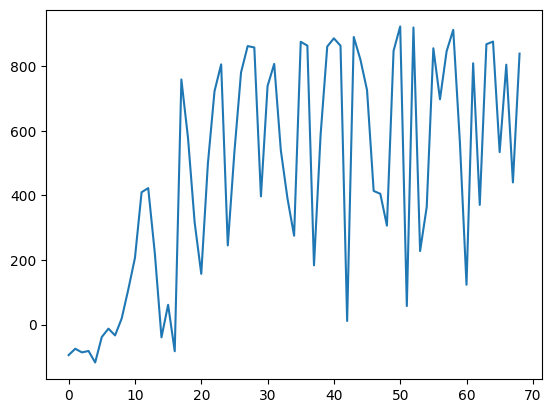

In [ ]:
import matplotlib.pyplot as plt

# Use rolling average to smooth the rewards graph (if necessary)
rolling_average_len = 1
smooth_rewards_graph = np.cumsum(rewards_graph)
smooth_rewards_graph = smooth_rewards_graph[rolling_average_len:] - smooth_rewards_graph[:-rolling_average_len]
smooth_rewards_graph = smooth_rewards_graph.astype(float) / rolling_average_len

plt.plot(smooth_rewards_graph)
plt.show()

[]

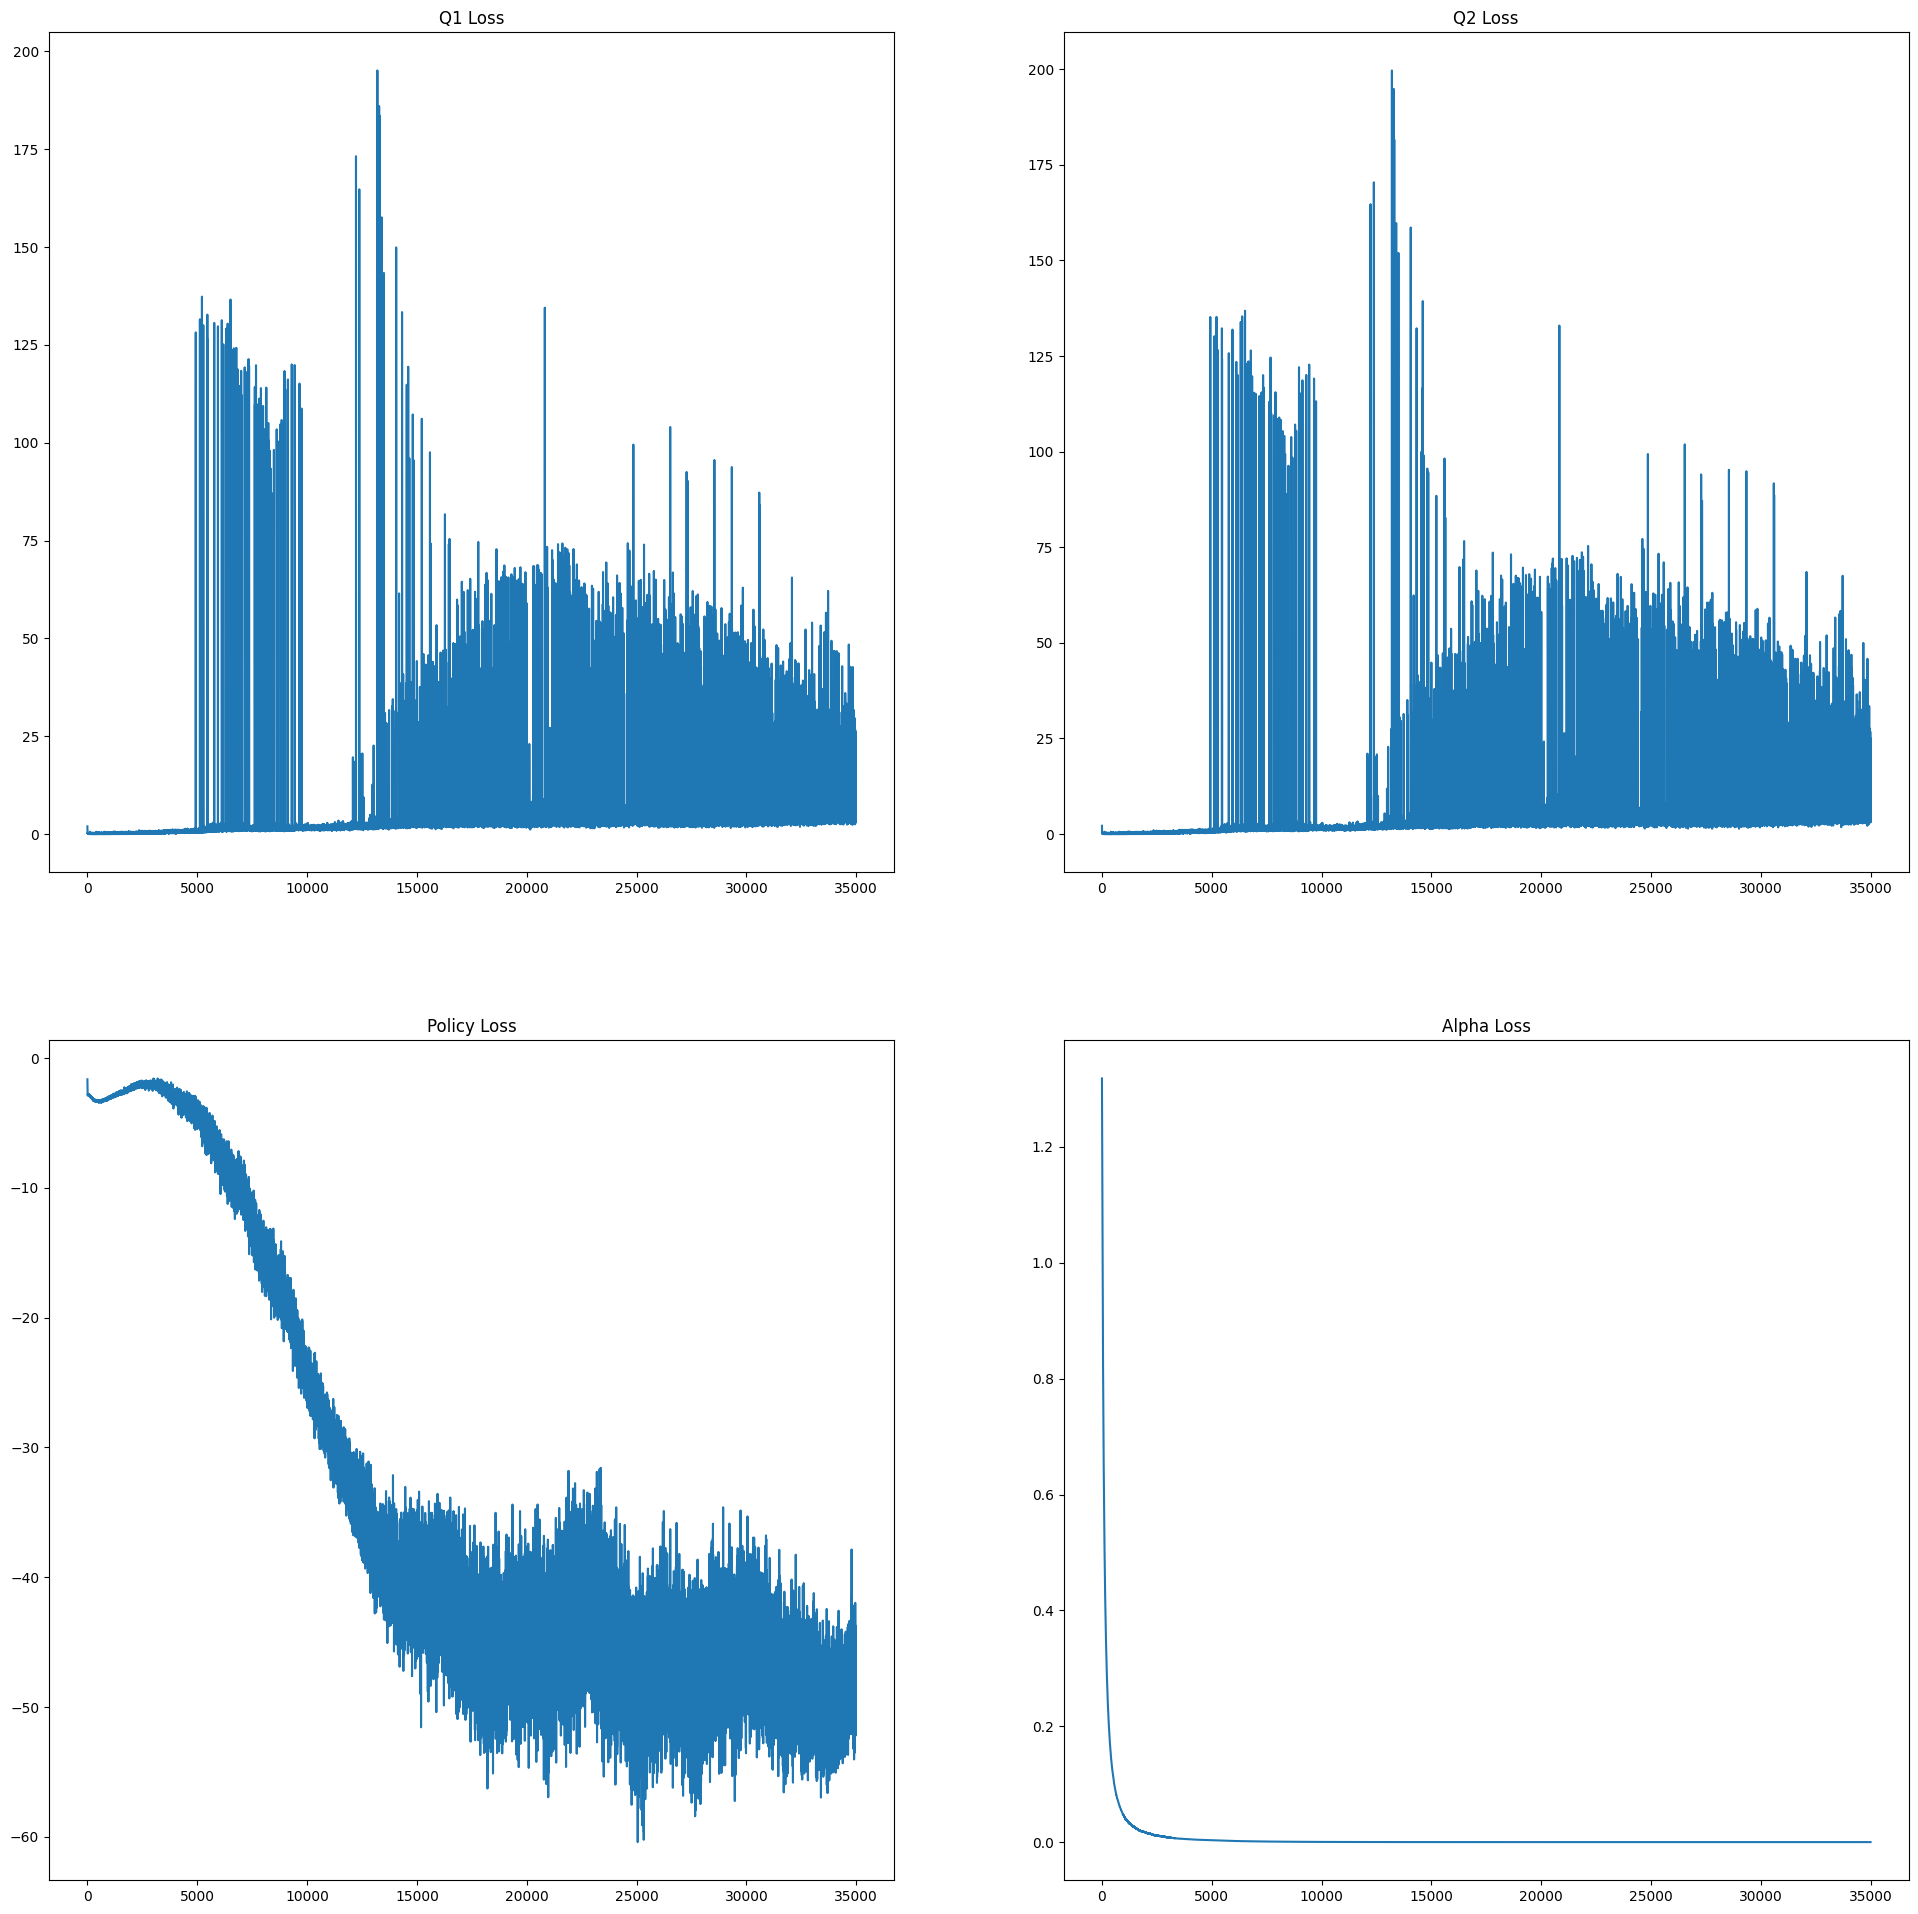

In [ ]:
# Plot losses
fig, axarr = plt.subplots(2, 2)

axarr[0, 0].plot(Q1_loss_graph)
axarr[0, 0].title.set_text("Q1 Loss")
axarr[0, 1].plot(Q2_loss_graph)
axarr[0, 1].title.set_text("Q2 Loss")
axarr[1, 0].plot(policy_loss_graph)
axarr[1, 0].title.set_text("Policy Loss")
axarr[1, 1].plot(alpha_loss_graph)
axarr[1, 1].title.set_text("Alpha Loss")
fig.set_size_inches(24, 24)
plt.plot()

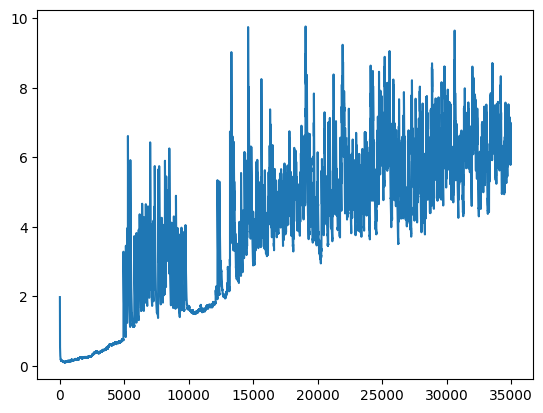

In [ ]:
# Plot Q-Loss, smoothing using exponential rolling average if necessary
factor = 0.98

smooth_Q_graph = []

avg = 0

for idx, i in enumerate(Q1_loss_graph):
    avg = factor * avg + (1 - factor) * i
    smooth_Q_graph.append(avg / (1 - factor ** (idx + 1)))
plt.plot(smooth_Q_graph)
plt.show()

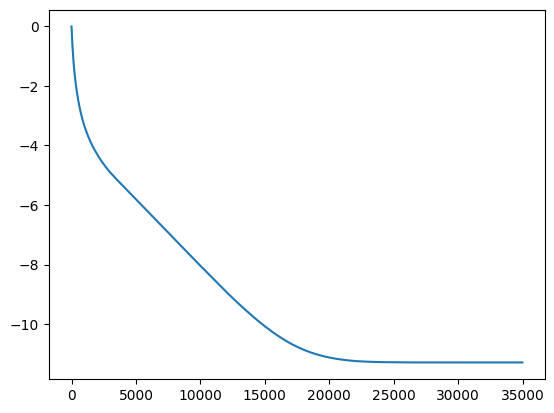

In [ ]:
# Plot log_alpha over time
plt.plot(log_alpha_graph)
plt.show()

Visualize Trained Policy

In [ ]:
%%capture
!apt update
!apt install xvfb
! pip install pyvirtualdisplay

In [ ]:
o, _ = env.reset()

for x in range(500):
    print(policy(torch.tensor(gs(o), device=device, dtype = torch.float32).unsqueeze(dim = 0).unsqueeze(dim = 0)))
    o, r, d, i, __ = env.step(int(torch.argmax(policy(torch.tensor(gs(o), device=device, dtype=torch.float32).unsqueeze(dim = 0).unsqueeze(dim = 0)))))

    if d or i:
        o, _ = env.reset()

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 1.1521e-38, 8.6486e-12]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[9.8091e-44, 5.7238e-39, 2.8026e-45, 7.4319e-30, 1.0000e+00]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[9.8234e-28, 9.3960e-24, 1.4013e-45, 9.4398e-33, 1.0000e+00]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[6.6590e-31, 1.0000e+00, 1.0926e-25, 0.0000e+00, 6.2797e-09]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[1.0429e-22, 3.9471e-10, 6.4421e-14, 2.1738e-28, 1.0000e+00]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[1.7920e-29, 5.5802e-14, 7.6555e-18, 4.7675e-25, 1.0000e+00]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[3.0523e-24, 2.5446e-10, 7.2608e-09, 1.9007e-23, 1.0000e+00]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[1.6539e-19, 1.0000e+00, 4.4813e-13, 7.2853e-20, 2.0155e-09]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[2.7593e

In [ ]:
import gym
from IPython import display
from pyvirtualdisplay import Display
from matplotlib import animation
import matplotlib.pyplot as plt

plt.rcParams['animation.embed_limit'] = 2**64

d = Display()
d.start()

o, _ = env.reset()
rewards_over_time = []
img = []
for x in range(1000):
    o, r, d, i, __ = env.step(int(torch.argmax(policy(torch.tensor(gs(o), device=device, dtype = torch.float32).unsqueeze(dim = 0).unsqueeze(dim=0)))))
    rewards_over_time.append(r)
    display.clear_output(wait=True)
    img.append(env.render())

    if d or i:
        o, _ = env.reset()

dpi = 72
interval = 50 # ms

plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
patch = plt.imshow(img[0])
plt.axis=('off')
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
display.display(display.HTML(ani.to_jshtml()))

In [ ]:
# Save render of trained policy
ani.save('CarRacingSAC3.gif', writer='imagemagick', fps=30)

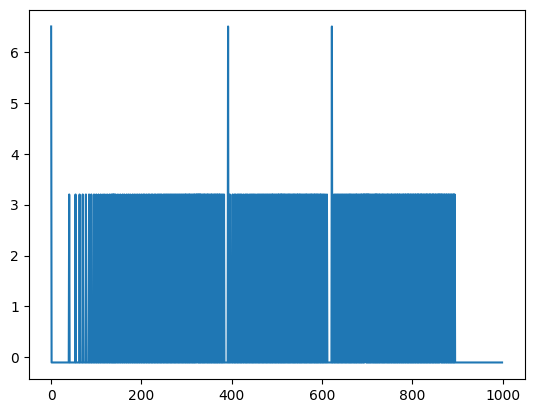

In [ ]:
plt.plot(rewards_over_time)

In [ ]:
# Save trained model weights
from google.colab import drive
drive.mount('/content/gdrive')

PATH = "/content/gdrive/My Drive/RL_SACVision/policy.pth"
torch.save(policy.state_dict(), PATH)
PATH = "/content/gdrive/My Drive/RL_SACVision/policy_opt.pth"
torch.save(policy_opt.state_dict(), PATH)
PATH = "/content/gdrive/My Drive/RL_SACVision/Q1.pth"
torch.save(Q1.state_dict(), PATH)
PATH = "/content/gdrive/My Drive/RL_SACVision/Q2.pth"
torch.save(Q2.state_dict(), PATH)
PATH = "/content/gdrive/My Drive/RL_SACVision/Q_opt.pth"
torch.save(Q_opt.state_dict(), PATH)
PATH = "/content/gdrive/My Drive/RL_SACVision/Q1targ.pth"
torch.save(Q1targ.state_dict(), PATH)
PATH = "/content/gdrive/My Drive/RL_SACVision/Q2targ.pth"
torch.save(Q2targ.state_dict(), PATH)
PATH = "/content/gdrive/My Drive/RL_SACVision/log_alpha_opt.pth"
torch.save(log_alpha_opt.state_dict(), PATH)
PATH = "/content/gdrive/MyDrive/RL_SACVision/log_alpha.txt"
with open(PATH, "w") as f:
    f.write(str(log_alpha.item()))

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/gdrive


‍